## import libraries

In [512]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import pandas as pd
import geopandas as gpd
import osmnx
from scipy.stats import zscore


In [513]:
#make plot interactive
plt.ion()

# 1)  Social Indicator

### Load & clean data 

In [514]:
# load the necessary data here 
admin = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Stadtteile_Hamburg.shp")
stats = pd.read_csv("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/statistics_HH21.csv",encoding="Latin-1", delimiter=";",decimal="." )
#admin
#print(stats.head())

In [516]:
#rename columns
stats.columns = ['district','inhabitants', 'pop<18','%<18', 'pop>65y','%>65', 'foreignResidents', 'migration_backg', 'hh','pp_size','hh_kids', '%hh_kids','areakm2', 'pop_density','working_pop', '%working_pop', 'unemployed','%unemployed','unemployed<18','%unemployed<18', 'unemployed>65', '%unemployed>65','social_benefits', '%social_benefits','social_housing', '%social_housing']
#stats


In [517]:
#joined population data with shapefile of admin boundaries and dropped additional columns in the admin dataset
admin_pop = pd.merge(admin,stats, left_on='stadtteil_', right_on='district', how = 'inner')

admin_pop.drop(columns=['OBJECTID','bezirk', 'stadttei_1', 'foreignResidents', 'migration_backg','pop<18' ],axis=1, inplace=True)

#admin_pop
#fig, ax = plt.subplots(figsize=(24, 18))
#admin_pop.plot(ax=ax, alpha=1,linewidth=2, facecolor="none")

In [ ]:
admin_pop.isnull().mean() * 100
admin_pop.dropna(subset=['%unemployed','%social_benefits','%social_housing','%unemployed>65' ], inplace=True)

#admin_pop.dropna(inplace=True)
#admin_pop.plot()
admin_pop

In [ ]:
# this line of code first subsets the dataframe so that only the columns relevant to the further anylsis (social status) are maintained
#this euqally makes sure to avoid non numeric values for normalization later on
#and calculates standard deviation to inform about the distribution
social_stats = admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65' ]]#std()

social_stats.hist()
social_stats.std()

In [511]:
#Uses the scipy Library in Python to calculate the z-score which helps to standardizes the values each column 

z_scores_admin_pop = admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65']].apply(zscore)

print(z_scores_admin_pop.std())

%unemployed         1.006309
%social_benefits    1.006309
%social_housing     1.006309
%unemployed>65      1.006309
dtype: float64


In [ ]:
#z_scores_admin_pop

### Analysis

In [ ]:
# calculates the mean of the columns
mean_socstats = z_scores_admin_pop[['%unemployed','%social_benefits','%social_housing','%unemployed>65', ]].mean(axis=1)
z_scores_admin_pop['mean_socstats'] = mean_socstats


In [ ]:
#groups / classifies the results into percentile of the respective column (equal quantiles 0 -4 (e.g. 0= lowest 20th quantile of mean / to  - 4 within highest 20th quantil))
z_scores_admin_pop ['qt_soc_stats'] = pd.qcut(z_scores_admin_pop ['mean_socstats'],5,labels=[0, 1, 2, 3, 4])


In [ ]:
# add text descripzion as an additional column
z_scores_admin_pop['status'] = ['very low' if x == 0 else
                       'low' if x == 1 else
                       'medium' if x == 2 else
                       'high' if x == 3 else
                       'very high' for x in z_scores_admin_pop['qt_soc_stats']]

z_scores_admin_pop.head()

In [ ]:
#merge the 2 frames to be able to plot the data later on
admin_socstats = pd.merge(admin_pop, z_scores_admin_pop, left_index=True, right_index=True)
admin_socstats.head()

In [ ]:
#save the final data set to cvs

### VISUALIZATION

<Axes: >

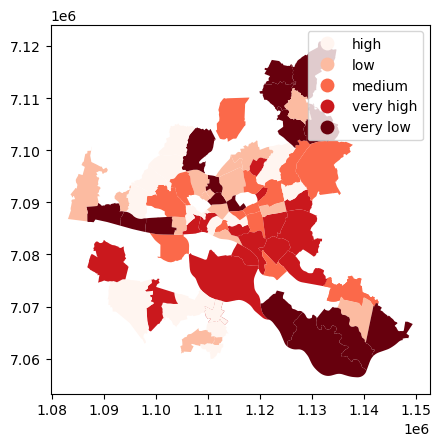

In [519]:
#plot output
admin_socstats.plot("status", cmap="Reds", legend=True)  

# 2) Environmental Indicators
uses noise, green areas (air pollution?, surface temperature? as indicator)

In [502]:
#load the data
noise = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Laermkarten_HH_2018-11-19.shp")
buildings = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Gebaeude_Hamburg.shp")
green_areas = gpd.read_file("C:/Users/charl/OneDrive/Desktop/ulster/EGM722_programming/git/egm722_project/data/Oeffentliche_Gruenanlage_Hamburg.shp")

In [518]:
# function to checks crs of different layers and reproject to epgs:Hamburg, GE to prepare for joining later on EPSG:25832
def reproject_to_local_epsg(gdf):
    # Check the CRS of the input GeoDataFrame
    print('Original CRS:', gdf.crs)

    # Reproject the GeoDataFrame to EPSG 25832
    gdf_reproj = gdf.to_crs(epsg=25832)

    # Check the CRS of the output GeoDataFrame
    print('Reprojected CRS:', gdf_reproj.crs)

    return gdf_reproj

# apply function
admin_pop_reproj = reproject_to_local_epsg(admin_pop)
noise_reproj = reproject_to_local_epsg(noise)
housing_reproj = reproject_to_local_epsg(housing)
green_areas_reproj = reproject_to_local_epsg(green_areas)


Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832
Original CRS: EPSG:25832
Reprojected CRS: EPSG:25832
Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832
Original CRS: EPSG:3857
Reprojected CRS: EPSG:25832


### Green areas 

In [504]:
#green_areas_reproj
green_areas_reproj.columns

Index(['OBJECTID', 'quelle_dat', 'idnr', 'dgpkey', 'benennung', 'belegenhei',
       'belegenh_1', 'gesamtanla', 'gesamtan_1', 'nutz_code', 'nutzung',
       'bezirk', 'stadtteil', 'ortsteil', 'gemarkung', 'veroeffent',
       'herrichtun', 'verwaltung', 'aktualitae', 'flaeche_ha', 'flaeche_qm',
       'stand', 'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')

In [505]:
#for green areas delete the values with code 10 - playground according to Alkis key and drop some of the unimportant columns
green_areas_reproj = green_areas_reproj[green_areas_reproj.nutzung != 10]
green_areas_reproj.drop(columns=['veroeffent','herrichtun', 'gesamtanla','aktualitae','idnr','belegenh_1','belegenhei','quelle_dat'],axis=1, inplace=True)

green_areas_reproj.head()

,OBJECTID,dgpkey,benennung,gesamtan_1,nutz_code,nutzung,bezirk,stadtteil,ortsteil,gemarkung,verwaltung,flaeche_ha,flaeche_qm,stand,SHAPE_Leng,SHAPE_Area,geometry
0,1,51580005,NaN,Schutz-Straßenbegleitgrün Rev 3,80,Schutzgrün,Wandsbek,Bramfeld,515,546,Stadtgrün,1.3090,13090,2021-02-16,1813.268251,37135.153073,"POLYGON ((571682.385 5940442.628, 571927.493 5..."
1,2,51550113,NaN,Osterbekoberlauf,50,Parkanlage,Wandsbek,Bramfeld,515,546,Stadtgrün,0.4478,4478,2021-02-16,920.409622,12697.549886,"POLYGON ((572254.058 5939481.930, 572254.220 5..."
2,3,52650280,NaN,Stellau Grün,50,Parkanlage,Wandsbek,Rahlstedt,526,544,Stadtgrün,0.2839,2839,2021-02-16,637.414887,8047.566252,"POLYGON ((577689.808 5938869.601, 577701.406 5..."
3,4,52650280,NaN,Stellau Grün,50,Parkanlage,Wandsbek,Rahlstedt,526,544,Stadtgrün,0.0746,746,2021-02-16,185.305657,2116.281875,"POLYGON ((577695.717 5938789.061, 577671.599 5..."
4,5,50950039,NaN,Gartenstadt,50,Parkanlage,Wandsbek,Wandsbek,509,552,AGV,0.0356,356,2021-02-16,252.935327,1008.046963,"POLYGON ((571054.670 5938638.040, 571054.878 5..."


In [506]:
# amend the data set by including forested areas from Open Street Map 




In [507]:
# intersect OSM with green area data set

In [508]:
#calculates area statistics of green spaces / district = stadtteil 2. calculate area / inhabitants
green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].sum() # sum of area in ha
green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'].mean() # mean area in ha
green_areas_reproj.groupby(['stadtteil'])['benennung'].count()  # bennenung: counts  of grean areas per district


stadtteil
Allermöhe              7
Alsterdorf             6
Altengamme             0
Altona-Altstadt       37
Altona-Nord            1
                    ... 
Wellingsbüttel         2
Wilhelmsburg         105
Wilstorf              13
Winterhude            52
Wohldorf-Ohlstedt      4
Name: benennung, Length: 96, dtype: int64

In [509]:
#2. calculate green area / inhabitants -- for that add some of the colums from admin data to green areas data set???
#green_areas_reproj['green_per_inhabitant']=green_areas_reproj.groupby(['stadtteil'])['flaeche_ha'] / ###
#green_areas_reproj['inhabitants']




In [510]:
#dissolve and add colums to data 
#add stats to data set to plot later